# SpaceX Epehmerides Test

In [1]:
from datetime import datetime, timedelta
import numpy as np
import json
import astropy.time
import astropy.units as u
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import DOP853, solve_ivp

import perturbations

In [2]:
truth_eph             = pd.read_csv('./test/spacex_test.csv')
truth_eph['time_dt']  = pd.to_datetime( truth_eph['time'] )
epoch                 = truth_eph.iloc[0]['time_dt']
truth_eph['tof']      = truth_eph['time_dt'].apply( lambda T: (T-epoch).total_seconds() )
total_tof             = ( truth_eph.iloc[-1]['time_dt'] - epoch ).total_seconds()
print('I see {:5.2f} hours , {} seconds of ephemeris'.format( total_tof/(60*60), total_tof ) )

I see 72.00 hours , 259200.0 seconds of ephemeris


In [27]:
# find the windows of the ephemeris
D1 = astropy.time.Time(truth_eph['time_dt'].iloc[0])
D2 = astropy.time.Time(truth_eph['time_dt'].iloc[-1])

# get the initial state vector
init_sv = truth_eph.iloc[0][ ['x','y','z','dx','dy','dz'] ].values
print('Initial state vector: {}'.format( init_sv ) )

# perturbations holder
P = perturbations.perturbations( D1, D2 )
P.addAll()
# P.addMoon()
# P.addJ2()
# P.addJ3()
# P.addAtmosphereExponential()

result = solve_ivp(
    P,
    (0, total_tof),
    init_sv,
    args=(),
    rtol=1e-10,
    atol=1e-12,
    method=DOP853,
    dense_output=True,
    events=None,
)

Initial state vector: [3365.2823685747 -2465.2687645879 5517.5075985359 4.3556076056
 6.2176993682 0.1219136402]


Initialized body_interp: 1152 total points, 600 second spacing, 690600.005145371 max offset, moon_callable function
Initialized body_interp: 1152 total points, 600 second spacing, 690600.005145371 max offset, sun_callable function


In [28]:
err_vals = []
for i,R in truth_eph.iterrows():
    teph = R[['x','y','z','dx','dy','dz']].values 
    ivp_r = result.sol( R['tof'] )
    err = teph - ivp_r
    err_vals.append( np.linalg.norm( err[:3] ) )

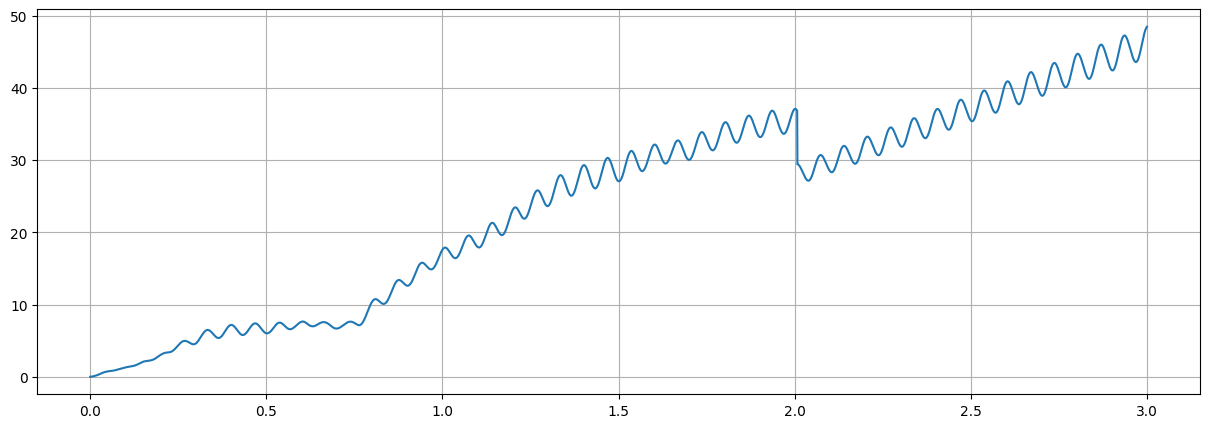

In [29]:
plt.close('all')
plt.figure( figsize=(15,5) )
plt.plot( truth_eph['tof']/86400, err_vals )
plt.grid()
plt.xlabel('Days since epoch')
plt.ylab